In [1]:
import os

import pickle
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       partitioned_averages)

In [2]:
def classical_solve(datapoint):
    seed, N_range = datapoint    
    gurobi_times,gurobi_iters  = [],[]
    mosek_times, mosek_iters   = [],[]
    for N in N_range:
        # Setting cardinality 
        k = N // 2
        # alpha in: s^T*mu + alpha*(s^T*Covar*s)
        alpha=0.5
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
        
        #------- GUROBI -------#
        
        # Defining binary optimization variable
        w = cp.Variable(shape=(N,),name='weights',boolean=True)
        # Defining objective
        objective = cp.Minimize(-expected_returns.T@w + alpha*cp.quad_form(w,covariances))
        # Defining constraints
        constraints = [cp.sum(w) == k]
        # Defining problem & solving it
        problem = cp.Problem(objective=objective, constraints=constraints)
        problem.solve(solver=cp.GUROBI, verbose=False)
        # Retrieving and saving stats
        stat, val, time, iter = problem.status, problem.value, problem.solver_stats.solve_time, problem.solver_stats.num_iters
        gurobi_times.append(time)
        gurobi_iters.append(iter)
        
        #------- MOSEK -------#
        
        # Defining binary optimization variable
        w = cp.Variable(shape=(N,),name='weights',boolean=True)
        # Defining objective
        objective = cp.Minimize(-expected_returns.T@w + alpha*cp.quad_form(w,covariances))
        # Defining constraints
        constraints = [cp.sum(w) == k]
        # Defining problem & solving it
        problem = cp.Problem(objective=objective, constraints=constraints)
        problem.solve(solver=cp.MOSEK, verbose=False)
        # Retrieving and saving stats
        stat, val, time, iter = problem.status, problem.value, problem.solver_stats.solve_time, problem.solver_stats.num_iters
        mosek_times.append(time)
        mosek_iters.append(iter)
    
    return {'mosek':{'times': mosek_times, 'iterations': mosek_iters},
            'gurobi':{'times': gurobi_times, 'iterations': gurobi_iters}}

In [3]:
N_min, N_max = 2, 150
N_seeds = 100
datapoints = []
for seed in range(N_seeds):
    datapoints.append((seed, range(N_min,N_max+1)))

In [4]:
results = Parallel(n_jobs=os.cpu_count()-2, verbose=51, backend='loky')(delayed(classical_solve)(datapoint) for datapoint in datapoints)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done  15 tasks      | elapsed:  

In [5]:
gurobi_time_results, gurobi_iter_results = [], []
mosek_time_results, mosek_iter_results = [], []
for result in results:
    gurobi_time_results.append(result['gurobi']['times'])
    gurobi_iter_results.append(result['gurobi']['iterations'])
    
    mosek_time_results.append(result['mosek']['times'])
    mosek_iter_results.append(result['mosek']['iterations'])

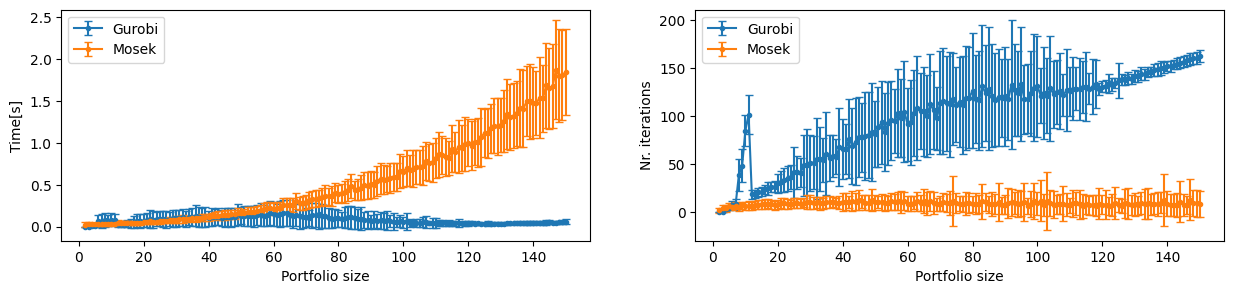

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].errorbar(list(range(N_min,N_max+1)), np.mean(gurobi_time_results,axis=0), yerr=np.std(gurobi_time_results,axis=0),fmt='.-', capsize=3, label='Gurobi')
ax[1].errorbar(list(range(N_min,N_max+1)), np.mean(gurobi_iter_results,axis=0), yerr=np.std(gurobi_iter_results,axis=0),fmt='.-', capsize=3, label='Gurobi')

ax[0].errorbar(list(range(N_min,N_max+1)), np.mean(mosek_time_results,axis=0), yerr=np.std(mosek_time_results,axis=0),fmt='.-', capsize=3, label='Mosek')
ax[1].errorbar(list(range(N_min,N_max+1)), np.mean(mosek_iter_results,axis=0), yerr=np.std(mosek_iter_results,axis=0),fmt='.-', capsize=3, label='Mosek')

ax[0].set_xlabel('Portfolio size')
ax[1].set_xlabel('Portfolio size')

ax[0].set_ylabel('Time[s]')
ax[1].set_ylabel('Nr. iterations')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.savefig('classical_scaling.png',dpi=300)